In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import tarfile
import urllib
import pandas as pd

In [2]:
from utils import load_housing_data, save_fig

In [3]:
housing = load_housing_data()

### 테스트 데이터셋 만들기

좋은 모델을 만들기 위해선 훌련에 사용되지 않고 모델 평가만을 위해서 사용될 "테스트 데이터셋"을 따로 구분하즌 것이 필요합니다. 테스트 데이터셋을 별도로 생성할 수도 있지만 프로젝트 초기의 경우 하나의 데이터셋을 훈련, 테스트용으로 분리하는 것이 일반적입니다.

In [4]:
# To make this notebook's output identical at every run
np.random.seed(42)

In [5]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio) : #{
    shuffle_indices = np.random.permutation(len(data))
    test_set_size   = int(len(data) * test_ratio)
    test_indices    = shuffle_indices[:test_set_size]
    train_indices   = shuffle_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
#}

In [6]:
a = np.random.permutation(10)
a

array([8, 1, 5, 0, 7, 2, 9, 4, 3, 6])

In [7]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

- 위 방법의 문제점은?  
  test data를 분리하는 작업 여러 번 할 수도 있음, 새로운 데이터가 추가 되었을 때 기존 test data가 train data가 될 수도 있음
- 해결 방안 : 각 샘플의 식별자(identifier)를 사용해서 분할

In [8]:
from zlib import crc32 ## hashing function

def test_set_check(identifier, test_ratio) : #{
    ## 0xffffffff : 2**32-1, 해싱 결과를 2^32로 나누었을 때의 나머지가 test_ratio * 2^32 보다 작으면 test data임
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32  
#}

def split_train_test_by_id(data, test_ratio, id_column) : #{
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]
#}

인덱스를 id로 추가하기

In [9]:
housing_with_id = housing.reset_index()  # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [10]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


- 위 방법의 문제점은?  
  행 번호를 id로 사용하면 데이터베이스가 업데이트되어 행들이 삭제될 가능성 있음 -> 뒤에 있던 행들이 올라와서 해당 행 번호가 될 수 있음.  
  새로운 데이터 추가 시 항상 맨 뒤에 추가 해야 앞에 있던 행들의 id가 영향 받지 않음
- 해결 방안 : id를 만드는 데 안전한 feature들을 사용해야함

In [12]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [14]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


Scikit-Learn에서 기본적으로 제공되는 데이터 분할 함수

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#### 계층적 샘플링 (Stratififed Sampling)
- 전체 데이터 계층(Strata)라는 동질의 그룹으로 나누고, 테스트 데이터가 전체 데이터를 잘 대표하도록 각 계층에서 올바른 수의 샘플을 추출

<AxesSubplot:>

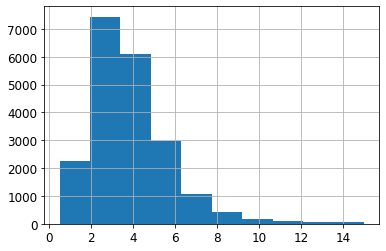

In [16]:
housing["median_income"].hist()

In [17]:
# 연속적인 값은 카테고리로 Grouping
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

In [18]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

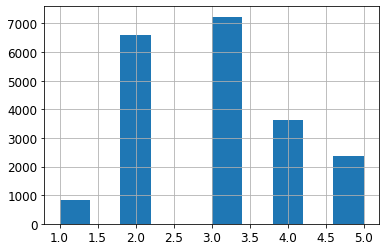

In [19]:
housing["income_cat"].hist()

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]) :
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [21]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16354 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   median_house_value  16512 non-null  float64 
 9   ocean_proximity     16512 non-null  object  
 10  income_cat          16512 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.4+ MB


In [22]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           4128 non-null   float64 
 1   latitude            4128 non-null   float64 
 2   housing_median_age  4128 non-null   float64 
 3   total_rooms         4128 non-null   float64 
 4   total_bedrooms      4079 non-null   float64 
 5   population          4128 non-null   float64 
 6   households          4128 non-null   float64 
 7   median_income       4128 non-null   float64 
 8   median_house_value  4128 non-null   float64 
 9   ocean_proximity     4128 non-null   object  
 10  income_cat          4128 non-null   category
dtypes: category(1), float64(9), object(1)
memory usage: 359.0+ KB


In [23]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [25]:
def income_cat_proportions(data) : #{
    return data["income_cat"].value_counts() / len(data)
#}

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall"    : income_cat_proportions(housing),
    "Stratified" : income_cat_proportions(strat_test_set),
    "Random"     : income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"]  = 100 * compare_props["Random"] / compare_props["Overall"]  - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [26]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [27]:
# 원래 상태로 되돌림
for set_ in (strat_train_set, strat_test_set) : #{
    set_.drop("income_cat", axis=1, inplace=True)
#}

## 3. 데이터 이해를 위한 탐색과 시각화

In [28]:
# 데이터 복사본 만들기 (훈련 데이터 손상시키지 않기 위해)
housing = strat_train_set.copy()

#### 지리적 데이터 시각화

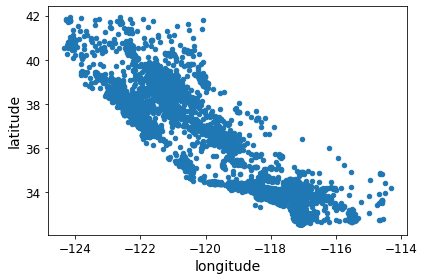

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

#### 밀집된 영역 표시
- alpha 옵션

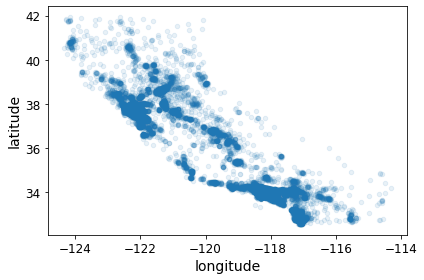

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

#### 더 다양한 정보 표시
- s : 원의 반지름 => 인구
- c : 색상 => 가격

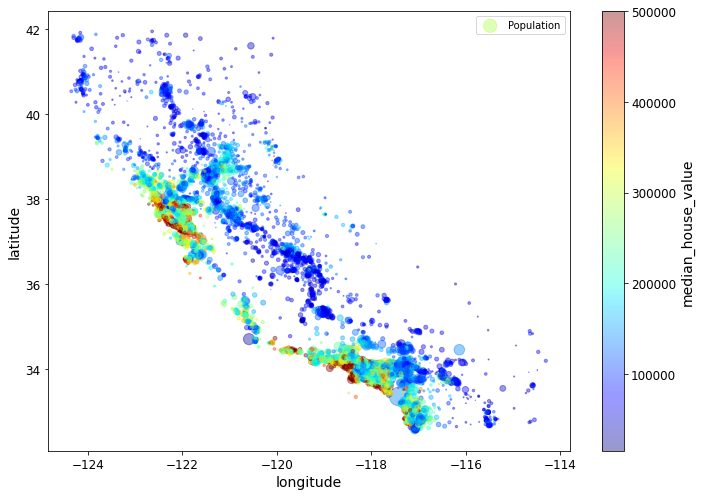

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="Population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [32]:
from utils import PROJECT_ROOT_DIR
# Download the California image
image_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(image_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master"
file_name     = "california.png"

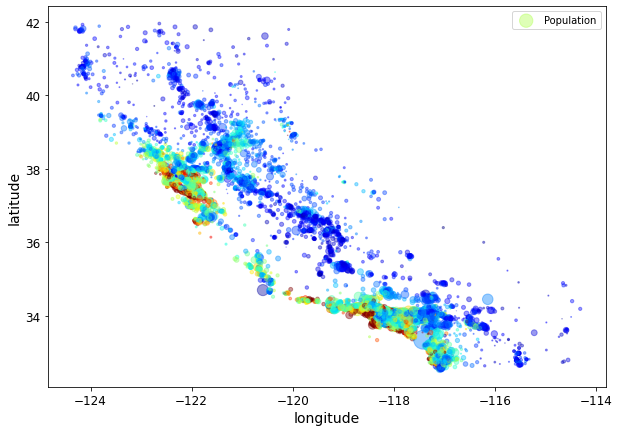

In [33]:
import matplotlib.image as mpimg
california_image = mpimg.imread(os.path.join(image_path, file_name))
x = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                 s=housing["population"]/100, label="Population", figsize=(10,7),
                 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=False,
                )

위에서 관찰할 수 있는 사실은(주택 가격이 높은 지역)?